## Librerias y carga de Dataset

In [1]:
# @title
import pandas as pd
import numpy as np
import gdown
import os
from sklearn.ensemble import IsolationForest
!pip install kmodes
from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import StandardScaler

In [2]:
# @title
file_id = '1VNArYveijKBtBKdIo7YCbVQITWxuyTQc'
url_dataset=f'https://drive.google.com/uc?id={file_id}'
name_of_data="DataCoSupplyChainDataset.csv"
if not os.path.exists(name_of_data):
    gdown.download(url_dataset,name_of_data,quiet=False)

df=pd.DataFrame(pd.read_csv(name_of_data,encoding='latin-1'))
df.dropna(subset=['Customer Lname', 'Customer Zipcode'],inplace=True)

df=df.drop(columns=['Customer Email','Customer Password','Product Image','Product Description','Order Zipcode'])




def clasificador(data):
    keys_class={"string":[],"numeric":[]}
    colum=data.columns
    for i in colum:
        world=type(df.loc[10000,i])
        if world==str:
            keys_class["string"].append(i)
        else:
            keys_class["numeric"].append(i)
    return keys_class




#preparation for clean all data before to train, detect anomalies
df_clients=df.groupby("Customer Id").agg({'Benefit per order':"sum",'Sales per customer':"sum",'Order Item Discount Rate': 'mean','Order Item Quantity': 'mean','Order Id': 'nunique'}).reset_index()

Downloading...
From: https://drive.google.com/uc?id=1VNArYveijKBtBKdIo7YCbVQITWxuyTQc
To: /content/DataCoSupplyChainDataset.csv
100%|██████████| 95.9M/95.9M [00:01<00:00, 86.4MB/s]


## Clasificacion

In [3]:
# @title
vars_modelo = ["Benefit per order","Sales per customer","Order Item Discount Rate","Order Item Quantity","Order Id"]
model=IsolationForest(contamination=0.07,random_state=13)
df_clients["Observation_Created"]=model.fit_predict(df_clients[vars_modelo])
print("The clients that are strange:")
print((df_clients["Observation_Created"]).value_counts())

The clients that are strange:
Observation_Created
 1    19196
-1     1445
Name: count, dtype: int64


In [4]:
# @title
regular_clients=df_clients[(df_clients["Observation_Created"]==1)|(df_clients["Benefit per order"]>=1000)]
rare_clients=df_clients[(df_clients["Observation_Created"]==-1)&(df_clients["Benefit per order"]<1000)]

In [5]:
# @title
df_modelo=regular_clients.copy()
cols_texto = ['Customer Segment', 'Order Region','Order City','Order Country']
info_texto = df.groupby('Order Customer Id')[cols_texto].first().reset_index()
df_final = pd.merge(df_modelo, info_texto, left_on='Customer Id', right_on='Order Customer Id', how='left')

In [6]:
cols_num=(df_final.columns).drop(cols_texto)

In [7]:
df_final

,Customer Id,Benefit per order,Sales per customer,Order Item Discount Rate,Order Item Quantity,Order Id,Observation_Created,Order Customer Id,Customer Segment,Order Region,Order City,Order Country
0,2,208.739999,1618.660042,0.126000,1.900000,4,1,2,Consumer,Central America,San Pedro Sula,Honduras
1,3,334.489999,3189.200037,0.105000,1.833333,5,1,3,Consumer,Oceania,Mount Gambier,Australia
2,4,-439.979992,1480.709993,0.135000,2.428571,4,1,4,Consumer,West Asia,Mersin,Turquía
3,5,309.850002,1101.919998,0.140000,2.571429,3,1,5,Home Office,West Africa,Lagos,Nigeria
4,6,893.649998,2954.320030,0.106667,3.133333,4,1,6,Consumer,Central America,Cancún,México
...,...,...,...,...,...,...,...,...,...,...,...,...
19527,20753,-107.959999,161.869995,0.250000,1.000000,1,1,20753,Consumer,Southeast Asia,Bekasi,Indonesia
19528,20754,-126.559998,172.660004,0.200000,1.000000,1,1,20754,Consumer,Southeast Asia,Bekasi,Indonesia
19529,20755,91.250000,314.640015,0.040000,1.000000,1,1,20755,Consumer,Southeast Asia,Bekasi,Indonesia
19530,20756,1.530000,10.910000,0.060000,1.000000,1,1,20756,Corporate,Southeast Asia,Bekasi,Indonesia


In [8]:
## En este punto se escala los valores numericos que seran necesarios
scaled=StandardScaler()
matrix_num=scaled.fit_transform(df_final[cols_num])
matrix_cat=df_final[cols_texto].values # esto es para nuestra matrix con palabras
# unimos todo en una sola matrix
total_matrix=np.hstack((matrix_num,matrix_cat))
# indices de las columnas que tiene texto
ind_texto=[8,9,10,11]

In [9]:
model_class=KPrototypes(n_clusters=3,init="Cao",verbose=1,random_state=13)
clusters_final=model_class.fit_predict(total_matrix,categorical=ind_texto)


Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 4269, ncost: 102917.45146984172
Run: 1, iteration: 2/100, moves: 1027, ncost: 102479.7519139245
Run: 1, iteration: 3/100, moves: 326, ncost: 102416.41684796938
Run: 1, iteration: 4/100, moves: 191, ncost: 102387.6539174339
Run: 1, iteration: 5/100, moves: 81, ncost: 102383.90899839408
Run: 1, iteration: 6/100, moves: 30, ncost: 102383.19512660815
Run: 1, iteration: 7/100, moves: 21, ncost: 102382.88926699095
Run: 1, iteration: 8/100, moves: 17, ncost: 102382.62245385828
Run: 1, iteration: 9/100, moves: 11, ncost: 102382.53226821683
Run: 1, iteration: 10/100, moves: 2, ncost: 102382.52940919674
Run: 1, iteration: 11/100, moves: 0, ncost: 102382.52940919674
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 3845, ncost: 102444.3809102426
Run

In [10]:
df_final["classification"]=clusters_final

In [11]:
df_final["classification"].value_counts()

,count
classification,
2,10722
1,8474
0,336


In [12]:
df_final

,Customer Id,Benefit per order,Sales per customer,Order Item Discount Rate,Order Item Quantity,Order Id,Observation_Created,Order Customer Id,Customer Segment,Order Region,Order City,Order Country,classification
0,2,208.739999,1618.660042,0.126000,1.900000,4,1,2,Consumer,Central America,San Pedro Sula,Honduras,2
1,3,334.489999,3189.200037,0.105000,1.833333,5,1,3,Consumer,Oceania,Mount Gambier,Australia,2
2,4,-439.979992,1480.709993,0.135000,2.428571,4,1,4,Consumer,West Asia,Mersin,Turquía,2
3,5,309.850002,1101.919998,0.140000,2.571429,3,1,5,Home Office,West Africa,Lagos,Nigeria,2
4,6,893.649998,2954.320030,0.106667,3.133333,4,1,6,Consumer,Central America,Cancún,México,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19527,20753,-107.959999,161.869995,0.250000,1.000000,1,1,20753,Consumer,Southeast Asia,Bekasi,Indonesia,1
19528,20754,-126.559998,172.660004,0.200000,1.000000,1,1,20754,Consumer,Southeast Asia,Bekasi,Indonesia,1
19529,20755,91.250000,314.640015,0.040000,1.000000,1,1,20755,Consumer,Southeast Asia,Bekasi,Indonesia,1
19530,20756,1.530000,10.910000,0.060000,1.000000,1,1,20756,Corporate,Southeast Asia,Bekasi,Indonesia,1


In [13]:
resumen = df_final.groupby('classification')[['Benefit per order', 'Sales per customer', 'Order Item Discount Rate',"Order Item Quantity"]].mean()

In [14]:
resumen

,Benefit per order,Sales per customer,Order Item Discount Rate,Order Item Quantity
classification,,,,
0,1289.106190,5323.200271,0.098670,2.226741
1,38.994341,265.278826,0.101513,1.013966
2,307.338520,2403.472950,0.101902,2.165214


In [15]:
# segun podemos ver que nuestros clientes vip son los de la categoria 0
# clientes que tenemos que son regulares tenemos que son el numero 2
# los clientes que estan en el numero 1 son nuestros clientes menos frecuentes y con poco beneficio

## df es toda la base de datos limpiada
## df_final tiene  el analisis de cada usuario individualmente y en la columna de classification esta en que categoria entra el usuario


## Prediccion de usuarios

In [16]:
# @title

# PUNTO 4: CLASIFICADOR DE CONSUMIDOR

# 1. PREPARAR LOS DATOS
print("\n[1] Preparando datos para el clasificador...")

# Usamos los clusters
X = df_final[['Benefit per order', 'Sales per customer',
              'Order Item Discount Rate', 'Order Item Quantity', 'Order Id']]

# Las etiquetas son los clusters
y = df_final['classification']

print(f" {len(X)} clientes listos para clasificar")
print(f"   Clase 0 (VIP): {(y == 0).sum()} clientes")
print(f"   Clase 1 (Ocasional): {(y == 1).sum()} clientes")
print(f"   Clase 2 (Regular): {(y == 2).sum()} clientes")


# 2. ENTRENAR EL MODELO SIMPLE

print("\n[2] Entrenando modelo simple...")

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo simple
modelo_simple = RandomForestClassifier(n_estimators=50, random_state=42)
modelo_simple.fit(X_train, y_train)

# Evaluar
y_pred = modelo_simple.predict(X_test)
precision = accuracy_score(y_test, y_pred)

print(f" Modelo entrenado con {len(X_train)} clientes")
print(f" Precisión: {precision*100:.1f}%")

# 3. FUNCIÓN PARA PREDECIR CLIENTES NUEVOS

print("\n[3] Creando función de predicción...")

def clasificar_cliente(beneficio, ventas, descuento, cantidad, pedidos):
    """
    Clasifica un cliente en VIP, Ocasional o Regular

    Args:
        beneficio: Benefit per order
        ventas: Sales per customer
        descuento: Order Item Discount Rate (ej: 0.15 para 15%)
        cantidad: Order Item Quantity (promedio)
        pedidos: Order Id (número de pedidos)

    Returns:
        dict: Categoría y detalles
    """
    # Crear datos del cliente
    datos_cliente = [[beneficio, ventas, descuento, cantidad, pedidos]]

    # Predecir
    categoria = modelo_simple.predict(datos_cliente)[0]
    probabilidades = modelo_simple.predict_proba(datos_cliente)[0]

    # Definir categorías
    categorias = {
        0: {"nombre": "CLIENTE VIP", "icono": "👑", "color": "oro"},
        1: {"nombre": "CLIENTE OCASIONAL", "icono": "🛍️", "color": "gris"},
        2: {"nombre": "CLIENTE REGULAR", "icono": "⭐", "color": "azul"}
    }

    info = categorias[categoria]

    return {
        "categoria": categoria,
        "nombre": info["nombre"],
        "icono": info["icono"],
        "color": info["color"],
        "probabilidades": {
            "VIP": f"{probabilidades[0]*100:.1f}%",
            "Ocasional": f"{probabilidades[1]*100:.1f}%",
            "Regular": f"{probabilidades[2]*100:.1f}%"
        }
    }


# 4. EJEMPLOS DE USO

print("\n[4] Probando con ejemplos:")

print("\n EJEMPLO 1: Cliente VIP")
print("-" * 30)
resultado1 = clasificar_cliente(
    beneficio=1500,    # Alto beneficio
    ventas=5000,       # Alto volumen
    descuento=0.08,    # Descuento bajo (8%)
    cantidad=2.8,      # Compra en volumen
    pedidos=10         # Muchos pedidos
)
print(f"{resultado1['icono']} {resultado1['nombre']}")
print(f"Probabilidad VIP: {resultado1['probabilidades']['VIP']}")



# 5. FUNCIÓN PARA CLIENTES EXISTENTES

print("\n[5] Analizando clientes del dataset:")

def analizar_cliente_existente(customer_id):
    """
    Analiza un cliente que ya está en el dataset
    """
    cliente = df_final[df_final['Customer Id'] == customer_id]

    if cliente.empty:
        return f"Cliente {customer_id} no encontrado"

    datos = cliente.iloc[0]

    # Clasificar
    resultado = clasificar_cliente(
        beneficio=datos['Benefit per order'],
        ventas=datos['Sales per customer'],
        descuento=datos['Order Item Discount Rate'],
        cantidad=datos['Order Item Quantity'],
        pedidos=datos['Order Id']
    )

    # Verificar si coincide con el cluster original
    cluster_original = datos['classification']
    coincide = "aplica" if resultado['categoria'] == cluster_original else "no aplica"

    return f"""
     Cliente {customer_id}
    {coincide} Clasificación: {resultado['icono']} {resultado['nombre']}
     Beneficio: ${datos['Benefit per order']:,.2f}
     Ventas: ${datos['Sales per customer']:,.2f}
     Región: {datos['Order Region']}
    """

# Probar con algunos clientes reales
print("\n Analizando 3 clientes reales:")
ids_ejemplo = df_final['Customer Id'].sample(3).tolist()
for id_cliente in ids_ejemplo:
    print(analizar_cliente_existente(id_cliente))


[1] Preparando datos para el clasificador...
 19532 clientes listos para clasificar
   Clase 0 (VIP): 336 clientes
   Clase 1 (Ocasional): 8474 clientes
   Clase 2 (Regular): 10722 clientes

[2] Entrenando modelo simple...
 Modelo entrenado con 15625 clientes
 Precisión: 97.9%

[3] Creando función de predicción...

[4] Probando con ejemplos:

 EJEMPLO 1: Cliente VIP
------------------------------
👑 CLIENTE VIP
Probabilidad VIP: 100.0%

[5] Analizando clientes del dataset:

 Analizando 3 clientes reales:

     Cliente 4811
    aplica Clasificación: ⭐ CLIENTE REGULAR
     Beneficio: $-180.87
     Ventas: $682.52
     Región: South Asia
    

     Cliente 11735
    aplica Clasificación: ⭐ CLIENTE REGULAR
     Beneficio: $591.99
     Ventas: $1,704.98
     Región: South America
    

     Cliente 4910
    aplica Clasificación: ⭐ CLIENTE REGULAR
     Beneficio: $132.83
     Ventas: $2,149.26
     Región: Central America
    


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

# Clasificacion geografica

## Clasificacion por regiones

In [17]:
# ============================================================
#   CLASIFICACIÓN GEOGRÁFICA SOLO POR REGIONES


import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report # Added classification_report


#   1. SELECCIONAR VARIABLES GEOGRÁFICAS

geo_vars = [
    "Customer City",
    "Customer State",
    "Customer Country",
    "Order City",
    "Order State",
    "Order Region", # This is the target variable
    "Latitude",
    "Longitude"
]

# Identify columns that are in geo_vars but not in df_final
missing_cols_in_df_final = [col for col in geo_vars if col not in df_final.columns]

# If there are missing columns, fetch them from the original 'df' and merge into 'df_final'
if missing_cols_in_df_final:
    # Group by 'Customer Id' and take the first occurrence for these columns
    # as df_final is customer-centric
    customer_geo_details = df.groupby('Customer Id')[missing_cols_in_df_final].first().reset_index()
    df_final = pd.merge(df_final, customer_geo_details, on='Customer Id', how='left')


# Dataset geográfico base for features (excluding 'Order Region' as it will be the target 'y')
# df_geo should contain only the features for prediction
df_geo_features = df_final[[col for col in geo_vars if col != 'Order Region']].copy()

# The class will be LA REGIÓN
y_geo = df_final["Order Region"]


#   2. CODIFICAR VARIABLES DE TEXTO

label_encoders = {}

# Apply LabelEncoder only to object type columns in df_geo_features
for col in df_geo_features.select_dtypes(include="object").columns:
    le = LabelEncoder()
    df_geo_features[col] = le.fit_transform(df_geo_features[col].astype(str))
    label_encoders[col] = le

# Also encode the target variable if it's categorical (Order Region is categorical)
le_target = LabelEncoder()
y_geo_encoded = le_target.fit_transform(y_geo)
label_encoders['Order Region'] = le_target # Store for inverse transform later


#   3. ESCALAR VARIABLES

scaler = StandardScaler()
X_geo_scaled = scaler.fit_transform(df_geo_features)


#  4. ENTRENAR MODELO DE CLASIFICACIÓN (RandomForest)


X_train, X_test, y_train, y_test = train_test_split(
    X_geo_scaled, y_geo_encoded, test_size=0.25, random_state=42, stratify=y_geo_encoded # Stratify for balanced splits
)

modelo_region = RandomForestClassifier(
    n_estimators=250,
    random_state=42
)

modelo_region.fit(X_train, y_train)

y_pred = modelo_region.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f" Precisión del modelo de regiones: {accuracy*100:.2f}%")
print("\n REPORTE DEL MODELO BASADO SOLO EN GEOGRAFÍA\n")
# Use inverse_transform to get original region names for classification_report
print(classification_report(le_target.inverse_transform(y_test), le_target.inverse_transform(y_pred)))


#   5. FUNCIÓN PARA CLASIFICAR UN NUEVO CLIENTE


def clasificar_region(customer_city, customer_state, customer_country,
                      order_city, order_state,
                      lat, lon):

    # Create a DataFrame for the new input, excluding 'Order Region' from the features
    input_geo_vars_for_prediction = [col for col in geo_vars if col != 'Order Region']
    datos = pd.DataFrame([[
        customer_city,
        customer_state,
        customer_country,
        order_city,
        order_state,
        lat,
        lon
    ]], columns=input_geo_vars_for_prediction)

    # Codificar texto using the stored label_encoders
    for col in datos.select_dtypes(include="object").columns:
        if col in label_encoders:
            le = label_encoders[col]
            datos[col] = le.transform(datos[col].astype(str))
        else:
            # Handle cases where a new value might appear or encoder wasn't fitted for a column
            # For simplicity, if not encoded, treat as unknown or raise error
            # For now, converting to string to avoid further issues, but this might need custom handling
            datos[col] = datos[col].astype(str)

    # Escalar
    datos_scaled = scaler.transform(datos)

    # Predicción de región (encoded)
    region_pred_encoded = modelo_region.predict(datos_scaled)[0]
    # Inverse transform to get the original region name
    region_pred = le_target.inverse_transform([region_pred_encoded])[0]
    return region_pred


# ============================================================
#   6. REPORTE FINAL DE CLIENTE POR REGIÓN
# ============================================================

def reporte_cliente_region(customer_id):

    cliente = df_final[df_final["Customer Id"] == customer_id]

    if cliente.empty:
        print(f"❌ Cliente {customer_id} no encontrado.")
        return

    row = cliente.iloc[0]

    # Use the actual 'Order Region' from df_final
    region = row["Order Region"]
    beneficio = row["Benefit per order"]
    ventas = row["Sales per customer"]

    # Products most sold in that region
    # We need to merge the original df with the 'Order Region' from df_final
    # to get product level details for the specific region.
    # When merging df (which has 'Order Region') with df_final[['Customer Id', 'Order Region']],
    # pandas renames the conflicting 'Order Region' columns to 'Order Region_x' (from df) and
    # 'Order Region_y' (from df_final). We want to filter by the region from df_final, hence 'Order Region_y'.
    df_temp_products_geo = pd.merge(
        df,
        df_final[['Customer Id', 'Order Region']],
        on='Customer Id',
        how='left'
    )

    productos_region = (
        df_temp_products_geo[df_temp_products_geo["Order Region_y"] == region] # Filter by 'Order Region_y'
        .groupby("Product Name")
        .agg({
            "Order Item Quantity": "sum",
            "Order Item Discount": "mean"
        })
        .sort_values("Order Item Quantity", ascending=False)
        .head(5)
    )

    print("\n===============================")
    print(f"🧍 Cliente {customer_id}")
    print("===============================")
    print(f"📌 Región: 🌍 {region}")
    print(f"💰 Beneficio por orden: ${beneficio:.2f}")
    print(f"🛒 Ventas por cliente: ${ventas:.2f}")

    print("\n⭐ Productos más vendidos en esta región:")
    print("---------------------------------------")
    for prod, info in productos_region.iterrows():
        print(f" • {prod} — Vendidos: {info['Order Item Quantity']} — "
              f"Descuento prom.: ${info['Order Item Discount']:.2f}")


#   7. EJEMPLO DE USO

# Cambia el ID por cualquier cliente del dataset
reporte_cliente_region(19179)


 Precisión del modelo de regiones: 74.77%

 REPORTE DEL MODELO BASADO SOLO EN GEOGRAFÍA

                 precision    recall  f1-score   support

         Canada       0.33      0.14      0.20        14
      Caribbean       0.78      0.59      0.67       135
 Central Africa       0.73      0.34      0.47        32
Central America       0.66      0.81      0.73       475
   Central Asia       0.17      0.11      0.13         9
    East Africa       0.50      0.21      0.30        33
    East of USA       0.74      0.62      0.67       108
   Eastern Asia       0.72      0.72      0.72       422
 Eastern Europe       0.35      0.14      0.20        65
   North Africa       0.61      0.34      0.44        50
Northern Europe       0.86      0.87      0.86       296
        Oceania       0.85      0.95      0.89       488
  South America       0.66      0.57      0.61       253
     South Asia       0.70      0.65      0.67       381
 South of  USA        0.71      0.32      0.44        6

## Por pais con random forest

In [18]:
# ---------------------------------------------
#    CLASIFICACIÓN GEOGRÁFICA POR PAÍS
#             USANDO RANDOM FOREST
# ---------------------------------------------

import pandas as pd
import numpy as np
import gdown
import os

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix




# -------------------------------------------------
# 2. LIMPIEZA BÁSICA
# -------------------------------------------------

df = df.dropna(subset=["Customer Country", "Latitude", "Longitude"])

# These columns were already dropped in cell 87de04c5
# df = df.drop(columns=[
#     'Customer Email', 'Customer Password',
#     'Product Image', 'Product Description',
#     'Order Zipcode'
# ])

# Dataset geográfico
df_geo = df[['Customer Country', 'Latitude', 'Longitude']].copy()

# Codificar país
df_geo = df_geo.dropna()
df_geo['Customer Country'] = df_geo['Customer Country'].astype(str)

print("Países detectados en el dataset:")
print(df_geo['Customer Country'].value_counts())
print("\n----------------------------------------\n")


# -------------------------------------------------
# 3. PREPARAR VARIABLES
# -------------------------------------------------

X = df_geo[['Latitude', 'Longitude']]
y = df_geo['Customer Country']

# División del dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)


# -------------------------------------------------
# 4. ENTRENAR RANDOM FOREST
# -------------------------------------------------

rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=4,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

print("\n🔵 PRECISIÓN DEL MODELO RANDOM FOREST")
print("Accuracy:", accuracy_score(y_test, y_pred))

print("\n🔵 MATRIZ DE CONFUSIÓN")
print(confusion_matrix(y_test, y_pred))

print("\n🔵 REPORTE DE CLASIFICACIÓN")
print(classification_report(y_test, y_pred))

print("\n----------------------------------------\n")


# -------------------------------------------------
# 5. FUNCIÓN PARA ELEGIR UN PAÍS Y MOSTRAR INFORME
# -------------------------------------------------

def reporte_pais(pais):
    """
    Muestra información completa del país:
    - Ventas totales
    - Categorías más vendidas
    - Productos más vendidos
    - Descuentos promedio
    """

    df_pais = df[df['Customer Country'] == pais]

    if df_pais.empty:
        return f"❌ No se encontraron datos para el país: {pais}"

    print(f"\n🌍 REPORTE COMPLETO PARA: {pais}")
    print("----------------------------------------")

    # Total de ventas
    ventas_totales = df_pais['Sales'].sum()
    print(f"💰 Ventas totales = ${ventas_totales:,.2f}")

    # Categorías de productos más vendidas
    print("\n🏷️ Categorías más vendidas:")
    print(df_pais.groupby("Category Name")['Order Item Quantity'].sum().sort_values(ascending=False).head(5))

    # Descuento promedio por categoría
    print("\n💸 Descuento promedio por categoría:")
    print(df_pais.groupby("Category Name")['Order Item Discount Rate'].mean().round(3))

    # Productos más vendidos
    print("\n📦 Productos más vendidos:")
    print(
        df_pais.groupby("Product Name")["Order Item Quantity"]
        .sum()
        .sort_values(ascending=False)
        .head(5)
    )

    # Descuento promedio general
    descuento_prom = df_pais['Order Item Discount Rate'].mean()
    print(f"\n🔻 Descuento promedio general: {descuento_prom:.3f}")

    print("\n----------------------------------------\n")


# -------------------------------------------------
# 6. LISTA DE PAÍSES Y OPCIÓN DE SELECCIÓN
# -------------------------------------------------

paises_disponibles = sorted(df['Customer Country'].unique())

print("🌎 Países disponibles:")
for i, p in enumerate(paises_disponibles):
    print(f"{i+1}. {p}")

print("\nPara consultar un país usa:")
print("reporte_pais('Ecuador')")
print("reporte_pais('United States')")
print("etc...\n")

Países detectados en el dataset:
Customer Country
EE. UU.        111137
Puerto Rico     69371
Name: count, dtype: int64

----------------------------------------


🔵 PRECISIÓN DEL MODELO RANDOM FOREST
Accuracy: 0.9993130498371263

🔵 MATRIZ DE CONFUSIÓN
[[27753    31]
 [    0 17343]]

🔵 REPORTE DE CLASIFICACIÓN
              precision    recall  f1-score   support

     EE. UU.       1.00      1.00      1.00     27784
 Puerto Rico       1.00      1.00      1.00     17343

    accuracy                           1.00     45127
   macro avg       1.00      1.00      1.00     45127
weighted avg       1.00      1.00      1.00     45127


----------------------------------------

🌎 Países disponibles:
1. EE. UU.
2. Puerto Rico

Para consultar un país usa:
reporte_pais('Ecuador')
reporte_pais('United States')
etc...



In [19]:
reporte_pais('EE. UU.')


🌍 REPORTE COMPLETO PARA: EE. UU.
----------------------------------------
💰 Ventas totales = $22,631,633.27

🏷️ Categorías más vendidas:
Category Name
Cleats                  45266
Women's Apparel         38762
Indoor/Outdoor Games    35391
Cardio Equipment        23134
Shop By Sport           20188
Name: Order Item Quantity, dtype: int64

💸 Descuento promedio por categoría:
Category Name
Accessories             0.102
As Seen on  TV!         0.103
Baby                    0.105
Baseball & Softball     0.104
Basketball              0.110
Books                   0.103
Boxing & MMA            0.104
CDs                     0.101
Cameras                 0.101
Camping & Hiking        0.102
Cardio Equipment        0.101
Children's Clothing     0.100
Cleats                  0.101
Computers               0.099
Consumer Electronics    0.103
Crafts                  0.104
DVDs                    0.102
Electronics             0.101
Fishing                 0.102
Fitness Accessories     0.103
Garden 

## Por estado

In [20]:
# ---------------------------------------------
#    CLASIFICACIÓN GEOGRÁFICA POR ESTADO
#             USANDO RANDOM FOREST
# ---------------------------------------------

import pandas as pd
import numpy as np
import gdown
import os

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix



# -------------------------------------------------
# 2. LIMPIEZA BÁSICA
# -------------------------------------------------

df = df.dropna(subset=["Customer State", "Latitude", "Longitude"])


# Dataset geográfico para estado
df_geo = df[['Customer State', 'Latitude', 'Longitude']].copy()
df_geo = df_geo.dropna()
df_geo['Customer State'] = df_geo['Customer State'].astype(str)

print("Estados detectados en el dataset:")
print(df_geo['Customer State'].value_counts())
print("\n----------------------------------------\n")


# -------------------------------------------------
# 3. PREPARAR VARIABLES
# -------------------------------------------------

X = df_geo[['Latitude', 'Longitude']]
y = df_geo['Customer State']

# División del dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)


# -------------------------------------------------
# 4. ENTRENAR RANDOM FOREST
# -------------------------------------------------

rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=4,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

print("\n🔵 PRECISIÓN DEL MODELO RANDOM FOREST")
print("Accuracy:", accuracy_score(y_test, y_pred))

print("\n🔵 MATRIZ DE CONFUSIÓN")
print(confusion_matrix(y_test, y_pred))

print("\n🔵 REPORTE DE CLASIFICACIÓN")
print(classification_report(y_test, y_pred))

print("\n----------------------------------------\n")


# -------------------------------------------------
# 5. FUNCIÓN PARA ELEGIR UN ESTADO Y MOSTRAR INFORME
# -------------------------------------------------

def reporte_estado(estado):
    """
    Muestra información completa del estado:
    - Ventas totales
    - Categorías más vendidas
    - Productos más vendidos
    - Descuentos promedio
    """

    df_estado = df[df['Customer State'] == estado]

    if df_estado.empty:
        return f"❌ No se encontraron datos para el estado: {estado}"

    print(f"\n🌍 REPORTE COMPLETO PARA EL ESTADO: {estado}")
    print("----------------------------------------")

    # Total de ventas
    ventas_totales = df_estado['Sales'].sum()
    print(f"💰 Ventas totales = ${ventas_totales:,.2f}")

    # Categorías más vendidas
    print("\n🏷️ Categorías más vendidas:")
    print(df_estado.groupby("Category Name")['Order Item Quantity'].sum().sort_values(ascending=False).head(5))

    # Descuento promedio por categoría
    print("\n💸 Descuento promedio por categoría:")
    print(df_estado.groupby("Category Name")['Order Item Discount Rate'].mean().round(3))

    # Productos más vendidos
    print("\n📦 Productos más vendidos:")
    print(
        df_estado.groupby("Product Name")["Order Item Quantity"]
        .sum()
        .sort_values(ascending=False)
        .head(5)
    )

    # Descuento promedio general
    descuento_prom = df_estado['Order Item Discount Rate'].mean()
    print(f"\n🔻 Descuento promedio general: {descuento_prom:.3f}")

    print("\n----------------------------------------\n")


# -------------------------------------------------
# 6. LISTA DE ESTADOS Y OPCIÓN DE SELECCIÓN
# -------------------------------------------------

estados_disponibles = sorted(df['Customer State'].unique())

print("🌎 Estados disponibles:")
for i, p in enumerate(estados_disponibles):
    print(f"{i+1}. {p}")

print("\nPara consultar un estado usa:")
print("reporte_estado('California')")
print("reporte_estado('Texas')")
print("reporte_estado('New York')")
print("etc...\n")


Estados detectados en el dataset:
Customer State
PR    69371
CA    29221
NY    11327
TX     9102
IL     7630
FL     5456
OH     4095
PA     3824
MI     3804
NJ     3191
AZ     3026
GA     2503
MD     2415
NC     1991
CO     1914
VA     1849
OR     1668
MA     1607
TN     1582
NV     1440
MO     1354
HI     1247
CT     1094
UT      968
NM      949
LA      948
WA      920
WI      850
MN      672
SC      665
IN      581
DC      579
KY      487
KS      458
DE      269
RI      243
WV      241
OK      232
ND      215
ID      167
AR      164
MT       87
IA       67
AL       35
Name: count, dtype: int64

----------------------------------------


🔵 PRECISIÓN DEL MODELO RANDOM FOREST
Accuracy: 0.9982272253861325

🔵 MATRIZ DE CONFUSIÓN
[[  9   0   0 ...   0   0   0]
 [  0  41   0 ...   0   0   0]
 [  0   0 755 ...   0   0   0]
 ...
 [  0   0   0 ... 230   0   0]
 [  0   0   0 ...   0 212   0]
 [  0   0   0 ...   0   0  60]]

🔵 REPORTE DE CLASIFICACIÓN
              precision    recall  f1-score 

In [21]:
reporte_estado('MO')


🌍 REPORTE COMPLETO PARA EL ESTADO: MO
----------------------------------------
💰 Ventas totales = $276,104.45

🏷️ Categorías más vendidas:
Category Name
Cleats                  495
Indoor/Outdoor Games    428
Women's Apparel         392
Cardio Equipment        264
Shop By Sport           243
Name: Order Item Quantity, dtype: int64

💸 Descuento promedio por categoría:
Category Name
Accessories             0.091
Baby                    0.160
Baseball & Softball     0.075
Books                   0.150
Boxing & MMA            0.090
CDs                     0.050
Cameras                 0.113
Camping & Hiking        0.104
Cardio Equipment        0.088
Children's Clothing     0.087
Cleats                  0.102
Computers               0.055
Consumer Electronics    0.120
Crafts                  0.125
Electronics             0.135
Fishing                 0.106
Fitness Accessories     0.107
Garden                  0.110
Girls' Apparel          0.123
Golf Apparel            0.135
Golf Balls     

## Por ciudad

In [22]:
# -------------------------------------------------------------
#     CLASIFICACIÓN GEOGRÁFICA POR CIUDAD (OPTIMIZADO)
#                   USANDO RANDOM FOREST
# -------------------------------------------------------------

import pandas as pd
import numpy as np
import gdown
import os

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score




# -------------------------------------------------------------
# 2. LIMPIEZA Y FILTRO DE CIUDADES
# -------------------------------------------------------------

# Quitar filas sin datos geográficos
df = df.dropna(subset=["Order City", "Latitude", "Longitude"])

df_geo = df[['Order City', 'Latitude', 'Longitude']].copy()
df_geo['Order City'] = df_geo['Order City'].astype(str)

# 🔥 Mantener solo ciudades con mínimo 2 registros
city_counts = df_geo['Order City'].value_counts()
cities_validas = city_counts[city_counts > 1].index

df_geo = df_geo[df_geo['Order City'].isin(cities_validas)]

print("🏙️ Ciudades incluidas en el modelo:")
print(df_geo['Order City'].value_counts())
print("\n-------------------------------------------------\n")


# -------------------------------------------------------------
# 3. MATRICES PARA ENTRENAMIENTO
# -------------------------------------------------------------

X = df_geo[['Latitude', 'Longitude']]
y = df_geo['Order City']


# -------------------------------------------------------------
# 4. ENTRENAMIENTO RANDOM FOREST (optimizado)
# -------------------------------------------------------------

# Modelo más ligero para no consumir RAM
rf_model = RandomForestClassifier(
    n_estimators=120,
    max_depth=20,
    min_samples_split=4,
    n_jobs=-1,
    random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

rf_model.fit(X_train, y_train)

pred = rf_model.predict(X_test)

print("\n🔵 PRECISIÓN DEL MODELO RANDOM FOREST")
print(f"Accuracy = {accuracy_score(y_test, pred):.4f}")

print("\n🔵 REPORTE DE CLASIFICACIÓN")
print(classification_report(y_test, pred, zero_division=0))

print("\n-------------------------------------------------\n")


# -------------------------------------------------------------
# 5. FUNCIÓN PARA CONSULTAR UNA CIUDAD
# -------------------------------------------------------------

def reporte_ciudad(ciudad):
    """
    Muestra:
    - Ventas totales
    - Categorías más vendidas
    - Productos más vendidos
    - Descuentos promedio
    """

    df_city = df[df['Order City'] == ciudad]

    if df_city.empty:
        return f"❌ No se encontraron datos para la ciudad: {ciudad}"

    print(f"\n🌍 REPORTE COMPLETO PARA: {ciudad}")
    print("-------------------------------------------------")

    # Total de ventas
    ventas_totales = df_city['Sales'].sum()
    print(f"💰 Ventas totales = ${ventas_totales:,.2f}")

    # Categorías más vendidas
    print("\n🏷️ Categorías más vendidas:")
    print(
        df_city.groupby("Category Name")['Order Item Quantity']
        .sum()
        .sort_values(ascending=False)
        .head(5)
    )

    # Productos más vendidos
    print("\n📦 Productos más vendidos:")
    print(
        df_city.groupby("Product Name")["Order Item Quantity"]
        .sum()
        .sort_values(ascending=False)
        .head(5)
    )

    # Descuento promedio
    print("\n💸 Descuento promedio general:")
    print(df_city['Order Item Discount Rate'].mean().round(3))

    print("-------------------------------------------------\n")


# -------------------------------------------------------------
# 6. LISTA DE CIUDADES DISPONIBLES
# -------------------------------------------------------------

ciudades_disponibles = sorted(df_geo['Order City'].unique())

print("🏙️ Ciudades disponibles para consultar:")
for i, c in enumerate(ciudades_disponibles):
    print(f"{i+1}. {c}")

print("\nUsa por ejemplo:")
print("reporte_ciudad('New York City')\n")


Se han truncado las últimas 5000 líneas del flujo de salida.
                           Mexicali       0.67      0.04      0.08        45
                        Mexico City       0.09      0.26      0.14       371
                            Meyzieu       0.17      0.17      0.17        12
                            Mezitli       0.25      0.25      0.25         4
                              Miami       0.22      0.17      0.19        35
                           Mianyang       0.29      0.12      0.17        16
                              Miass       0.00      0.00      0.00         9
                      Middlesbrough       0.17      0.14      0.15        14
                         Middletown       0.25      0.17      0.20         6
                            Midland       0.00      0.00      0.00         7
                     Miguel Hidalgo       0.07      0.04      0.05        24
                              Mijas       1.00      0.50      0.67         4
               

#TASK

In [23]:
# @title
mean_benefit_original = df['Benefit per order'].mean()
mean_sales_original = df['Sales per customer'].mean()

print("Rentabilidad General (Línea Base - Dataset Original):")
print(f"Beneficio promedio por orden: ${mean_benefit_original:.2f}")
print(f"Ventas promedio por cliente: ${mean_sales_original:.2f}")

Rentabilidad General (Línea Base - Dataset Original):
Beneficio promedio por orden: $21.97
Ventas promedio por cliente: $183.10


In [24]:
# @title
import pandas as pd
import gdown
import os

# Re-load df as it seems not defined in the current kernel session
file_id = '1VNArYveijKBtBKdIo7YCbVQITWxuyTQc'
url_dataset=f'https://drive.google.com/uc?id={file_id}'
name_of_data="DataCoSupplyChainDataset.csv"
if not os.path.exists(name_of_data):
    gdown.download(url_dataset,name_of_data,quiet=False)

df=pd.DataFrame(pd.read_csv(name_of_data,encoding='latin-1'))
df.dropna(subset=['Customer Lname', 'Customer Zipcode'],inplace=True)
df=df.drop(columns=['Customer Email','Customer Password','Product Image','Product Description','Order Zipcode'])

mean_benefit_original = df['Benefit per order'].mean()
mean_sales_original = df['Sales per customer'].mean()

print("Rentabilidad General (Línea Base - Dataset Original):")
print(f"Beneficio promedio por orden: ${mean_benefit_original:.2f}")
print(f"Ventas promedio por cliente: ${mean_sales_original:.2f}")

Rentabilidad General (Línea Base - Dataset Original):
Beneficio promedio por orden: $21.97
Ventas promedio por cliente: $183.10


In [25]:
# @title
print(f"**Rentabilidad por Clústeres (K-Prototypes):**")
display(resumen[['Benefit per order', 'Sales per customer']])

**Rentabilidad por Clústeres (K-Prototypes):**


,Benefit per order,Sales per customer
classification,,
0,1289.106190,5323.200271
1,38.994341,265.278826
2,307.338520,2403.472950


In [26]:
# @title
import numpy as np
from sklearn.ensemble import IsolationForest
from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import StandardScaler

# Re-creating df_clients
df_clients=df.groupby("Customer Id").agg({'Benefit per order':"sum",'Sales per customer':"sum",'Order Item Discount Rate': 'mean','Order Item Quantity': 'mean','Order Id': 'nunique'}).reset_index()

# Re-creating Observation_Created
vars_modelo = ["Benefit per order","Sales per customer","Order Item Discount Rate","Order Item Quantity","Order Id"]
model=IsolationForest(contamination=0.07,random_state=13)
df_clients["Observation_Created"]=model.fit_predict(df_clients[vars_modelo])

# Re-creating regular_clients and rare_clients
regular_clients=df_clients[(df_clients["Observation_Created"]==1)|(df_clients["Benefit per order"]>=1000)]
rare_clients=df_clients[(df_clients["Observation_Created"]==-1)&(df_clients["Benefit per order"]<1000)]

# Re-creating df_final
df_modelo=regular_clients.copy()
cols_texto = ['Customer Segment', 'Order Region','Order City','Order Country']
info_texto = df.groupby('Order Customer Id')[cols_texto].first().reset_index()
df_final = pd.merge(df_modelo, info_texto, left_on='Customer Id', right_on='Order Customer Id', how='left')

# Re-creating cols_num
cols_num=(df_final.columns).drop(cols_texto)

# Re-creating scaled matrices for KPrototypes
scaled=StandardScaler()
matrix_num=scaled.fit_transform(df_final[cols_num])
matrix_cat=df_final[cols_texto].values
total_matrix=np.hstack((matrix_num,matrix_cat))
ind_texto=[8,9,10,11]

# Re-running KPrototypes model
model_class=KPrototypes(n_clusters=3,init="Cao",verbose=0,random_state=13) # verbose=0 to reduce output
clusters_final=model_class.fit_predict(total_matrix,categorical=ind_texto)

# Assigning classification to df_final
df_final["classification"]=clusters_final

# Calculating resumen
resumen = df_final.groupby('classification')[['Benefit per order', 'Sales per customer', 'Order Item Discount Rate',"Order Item Quantity"]].mean()

# Displaying the result
print(f"**Rentabilidad por Clústeres (K-Prototypes):**")
display(resumen[['Benefit per order', 'Sales per customer']])

**Rentabilidad por Clústeres (K-Prototypes):**


,Benefit per order,Sales per customer
classification,,
0,1289.106190,5323.200271
1,38.994341,265.278826
2,307.338520,2403.472950


In [27]:
# @title
!pip install kmodes
import numpy as np
from sklearn.ensemble import IsolationForest
from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import StandardScaler

# Re-creating df_clients
df_clients=df.groupby("Customer Id").agg({'Benefit per order':"sum",'Sales per customer':"sum",'Order Item Discount Rate': 'mean','Order Item Quantity': 'mean','Order Id': 'nunique'}).reset_index()

# Re-creating Observation_Created
vars_modelo = ["Benefit per order","Sales per customer","Order Item Discount Rate","Order Item Quantity","Order Id"]
model=IsolationForest(contamination=0.07,random_state=13)
df_clients["Observation_Created"]=model.fit_predict(df_clients[vars_modelo])

# Re-creating regular_clients and rare_clients
regular_clients=df_clients[(df_clients["Observation_Created"]==1)|(df_clients["Benefit per order"]>=1000)]
rare_clients=df_clients[(df_clients["Observation_Created"]==-1)&(df_clients["Benefit per order"]<1000)]

# Re-creating df_final
df_modelo=regular_clients.copy()
cols_texto = ['Customer Segment', 'Order Region','Order City','Order Country']
info_texto = df.groupby('Order Customer Id')[cols_texto].first().reset_index()
df_final = pd.merge(df_modelo, info_texto, left_on='Customer Id', right_on='Order Customer Id', how='left')

# Re-creating cols_num
cols_num=(df_final.columns).drop(cols_texto)

# Re-creating scaled matrices for KPrototypes
scaled=StandardScaler()
matrix_num=scaled.fit_transform(df_final[cols_num])
matrix_cat=df_final[cols_texto].values
total_matrix=np.hstack((matrix_num,matrix_cat))
ind_texto=[8,9,10,11]

# Re-running KPrototypes model
model_class=KPrototypes(n_clusters=3,init="Cao",verbose=0,random_state=13) # verbose=0 to reduce output
clusters_final=model_class.fit_predict(total_matrix,categorical=ind_texto)

# Assigning classification to df_final
df_final["classification"]=clusters_final

# Calculating resumen
resumen = df_final.groupby('classification')[['Benefit per order', 'Sales per customer', 'Order Item Discount Rate',"Order Item Quantity"]].mean()

In [28]:
# @title
# Displaying the result
print(f"Rentabilidad por Clústeres (K-Prototypes):\n")
display(resumen[['Benefit per order', 'Sales per customer']])

Rentabilidad por Clústeres (K-Prototypes):



,Benefit per order,Sales per customer
classification,,
0,1289.106190,5323.200271
1,38.994341,265.278826
2,307.338520,2403.472950


**Reasoning**:
Now that the rentability by cluster has been successfully displayed, the next step is to calculate and display the rentability by anomaly detection. This involves calculating the mean benefit per order and sales per customer for both `regular_clients` and `rare_clients` and printing the results with descriptive labels and currency formatting.



In [31]:
# @title
mean_benefit_regular = regular_clients['Benefit per order'].mean()
mean_sales_regular = regular_clients['Sales per customer'].mean()

mean_benefit_rare = rare_clients['Benefit per order'].mean()
mean_sales_rare = rare_clients['Sales per customer'].mean()

print(f"**Rentabilidad por Detección de Anomalías:**")
print(f"\n**Clientes Regulares:**")
print(f"Beneficio promedio por orden: ${mean_benefit_regular:.2f}")
print(f"Ventas promedio por cliente: ${mean_sales_regular:.2f}")

print(f"\n**Clientes Anómalos (Raros):**")
print(f"Beneficio promedio por orden: ${mean_benefit_rare:.2f}")
print(f"Ventas promedio por cliente: ${mean_sales_rare:.2f}")

**Rentabilidad por Detección de Anomalías:**

**Clientes Regulares:**
Beneficio promedio por orden: $207.81
Ventas promedio por cliente: $1526.04

**Clientes Anómalos (Raros):**
Beneficio promedio por orden: $-83.70
Ventas promedio por cliente: $2925.81


⚙️ Procesando Perfiles de Cliente y Valor de Vida (CLV)...

===== RESULTADOS DEL MODELO =====
              precision    recall  f1-score   support

           0       0.72      0.58      0.65      1027
           1       0.92      0.96      0.94      5169

    accuracy                           0.89      6196
   macro avg       0.82      0.77      0.79      6196
weighted avg       0.89      0.89      0.89      6196

AUC Score: 0.9336


/tmp/ipython-input-3485585215.py:155: UserWarning: Glyph 129353 (\N{THIRD PLACE MEDAL}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-3485585215.py:155: UserWarning: Glyph 129352 (\N{SECOND PLACE MEDAL}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-3485585215.py:155: UserWarning: Glyph 129351 (\N{FIRST PLACE MEDAL}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129353 (\N{THIRD PLACE MEDAL}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129352 (\N{SECOND PLACE MEDAL}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129351 (\N{FIRST PLACE MEDAL}) missing from font(s) Liberation

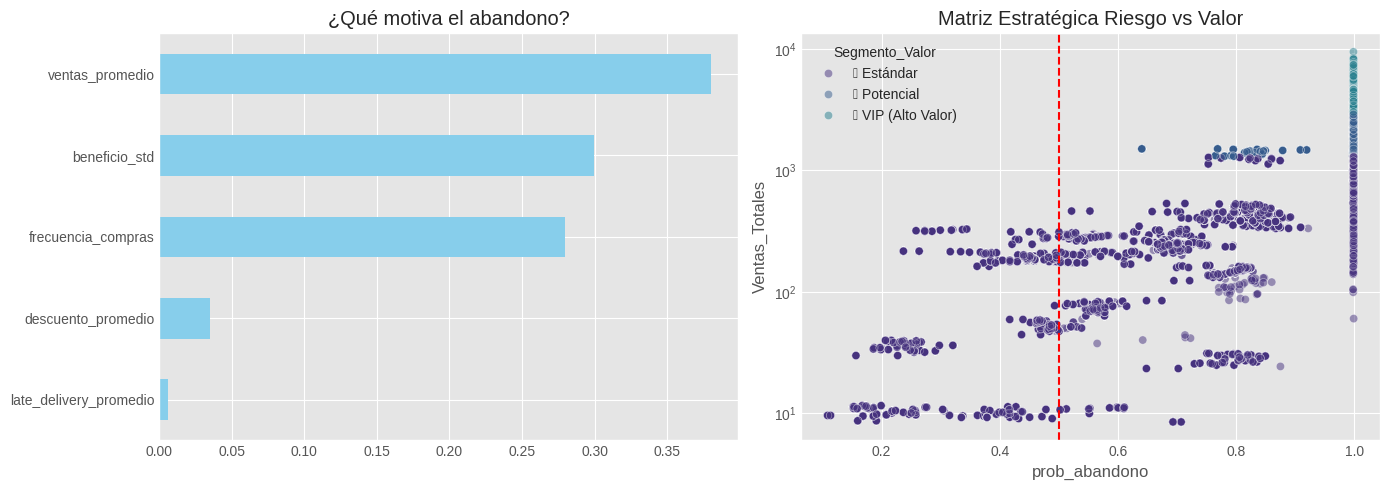


📊 EXPEDIENTE DEL CLIENTE: 3360
💰 VALOR HISTÓRICO: $2,940.09 | Segmento: 🥇 VIP (Alto Valor)
📦 PREFERENCIA: Men's Footwear | Inactividad: 359 días
⚠️ PROBABILIDAD DE FUGA: 99.9%
-----------------------------------------------------------------
PRIORIDAD: 🔴 CRÍTICO (Fuga de Capital)
ACCIÓN: LLAMADA DIRECTA + BONO VIP en Men's Footwear.



In [48]:
# =================================================================
# ESTRATEGIA 360°: PREDICCIÓN DE CHURN Y VALOR DEL CLIENTE (CLV)
# =================================================================

import os
import gdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Configuración de estilo para la presentación
plt.style.use('ggplot')
sns.set_palette("viridis")

# 1. CARGA DEL DATASET
file_id = '1VNArYveijKBtBKdIo7YCbVQITWxuyTQc'
url_dataset = f'https://drive.google.com/uc?id={file_id}'
name_of_data = "DataCoSupplyChainDataset.csv"

if not os.path.exists(name_of_data):
    print("📥 Descargando dataset...")
    gdown.download(url_dataset, name_of_data, quiet=False)

df = pd.read_csv(name_of_data, encoding='latin-1')

# 2. FEATURE ENGINEERING Y MÉTRICAS DE CLIENTE
print("⚙️ Procesando Perfiles de Cliente y Valor de Vida (CLV)...")

df.dropna(subset=['Customer Id', 'order date (DateOrders)'], inplace=True)
df['order date (DateOrders)'] = pd.to_datetime(df['order date (DateOrders)'])
fecha_actual = df['order date (DateOrders)'].max()

# Agregamos variables de comportamiento y de valor financiero
cliente_df = df.groupby('Customer Id').agg({
    'order date (DateOrders)': lambda x: (fecha_actual - x.max()).days, # Recencia
    'Order Id': 'count',                                               # Frecuencia
    'Sales per customer': ['mean', 'sum'],                             # Valor
    'Benefit per order': ['mean', 'std'],                              # Rentabilidad
    'Late_delivery_risk': 'mean',                                      # Logística
    'Order Item Discount Rate': 'mean',                                # Sensibilidad precio
    'Category Name': lambda x: x.mode()[0] if not x.mode().empty else 'N/A' # Preferencia
}).reset_index()

# Aplanamos las columnas
cliente_df.columns = [
    'Customer Id', 'dias_desde_ultima_compra', 'frecuencia_compras',
    'ventas_promedio', 'Ventas_Totales', 'beneficio_promedio',
    'beneficio_std', 'late_delivery_promedio', 'descuento_promedio', 'Categoria_Favorita'
]
cliente_df.fillna(0, inplace=True)

# 3. ETIQUETADO DE RIESGO (Lógica de Negocio)
cliente_df['riesgo_abandono'] = (
    (cliente_df['dias_desde_ultima_compra'] > 60) |
    (cliente_df['beneficio_promedio'] < 0)
).astype(int)

# 4. SEGMENTACIÓN POR VALOR (Ranking VIP)
def segmentar_valor(row):
    if row['Ventas_Totales'] > cliente_df['Ventas_Totales'].quantile(0.8):
        return '🥇 VIP (Alto Valor)'
    elif row['Ventas_Totales'] > cliente_df['Ventas_Totales'].quantile(0.5):
        return '🥈 Potencial'
    else:
        return '🥉 Estándar'

cliente_df['Segmento_Valor'] = cliente_df.apply(segmentar_valor, axis=1)

# 5. ENTRENAMIENTO DEL MODELO (Gradient Boosting)
features = [
    'frecuencia_compras', 'late_delivery_promedio',
    'descuento_promedio', 'ventas_promedio', 'beneficio_std'
]

X = cliente_df[features]
y = cliente_df['riesgo_abandono']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

modelo_gb = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    random_state=42
)

modelo_gb.fit(X_train, y_train)

# Guardamos las probabilidades en el DataFrame principal
cliente_df['prob_abandono'] = modelo_gb.predict_proba(X)[:, 1]

# 6. FUNCIÓN DE ANALÍTICA 360° PARA EL PITCH
def motor_analitica_360(id_cliente):
    """Diagnóstico financiero y predictivo del cliente."""
    cliente = cliente_df[cliente_df['Customer Id'] == id_cliente]
    if cliente.empty: return print("Cliente no encontrado")

    c = cliente.iloc[0]
    prob = c['prob_abandono']

    print(f"\n{'='*65}")
    print(f"📊 EXPEDIENTE DEL CLIENTE: {id_cliente}")
    print(f"{'='*65}")
    print(f"💰 VALOR HISTÓRICO: ${c['Ventas_Totales']:,.2f} | Segmento: {c['Segmento_Valor']}")
    print(f"📦 PREFERENCIA: {c['Categoria_Favorita']} | Inactividad: {c['dias_desde_ultima_compra']} días")
    print(f"⚠️ PROBABILIDAD DE FUGA: {prob*100:.1f}%")
    print(f"{'-'*65}")

    # Estrategia de Retención
    if prob > 0.65 and 'VIP' in c['Segmento_Valor']:
        status, accion = "🔴 CRÍTICO (Fuga de Capital)", f"LLAMADA DIRECTA + BONO VIP en {c['Categoria_Favorita']}."
    elif prob > 0.65:
        status, accion = "🟡 RIESGO ALTO", "Cupón automático de rescate (20% OFF)."
    elif prob < 0.35 and 'VIP' in c['Segmento_Valor']:
        status, accion = "💎 CLIENTE ESTRELLA", "Invitación exclusiva a programa de lealtad."
    else:
        status, accion = "🟢 SALUDABLE", "Mantener flujo de comunicación estándar."

    print(f"PRIORIDAD: {status}")
    print(f"ACCIÓN: {accion}")
    print(f"{'='*65}\n")

# 7. VISUALIZACIÓN DE MÉTRICAS (Rúbricas y Estrategia)
def mostrar_visualizaciones():
    y_pred = modelo_gb.predict(X_test)

    print("\n===== RESULTADOS DEL MODELO =====")
    print(classification_report(y_test, y_pred))
    print(f"AUC Score: {roc_auc_score(y_test, modelo_gb.predict_proba(X_test)[:, 1]):.4f}")

    # Gráfico 1: Importancia de Variables
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    importancias = pd.Series(modelo_gb.feature_importances_, index=features).sort_values()
    importancias.plot(kind='barh', color='skyblue')
    plt.title('¿Qué motiva el abandono?')

    # Gráfico 2: Matriz Riesgo vs Valor
    plt.subplot(1, 2, 2)
    sns.scatterplot(data=cliente_df, x='prob_abandono', y='Ventas_Totales',
                    hue='Segmento_Valor', alpha=0.5)
    plt.axvline(0.5, color='red', linestyle='--')
    plt.yscale('log')
    plt.title('Matriz Estratégica Riesgo vs Valor')

    plt.tight_layout()
    plt.show()

# --- EJECUCIÓN ---
mostrar_visualizaciones()

# Probar con el cliente VIP con mayor riesgo detectado
vip_peligro = cliente_df[cliente_df['Segmento_Valor'] == '🥇 VIP (Alto Valor)'].sort_values('prob_abandono', ascending=False)
if not vip_peligro.empty:
    motor_analitica_360(vip_peligro['Customer Id'].iloc[0])

⚙️ Procesando ADN del cliente, Geografía y Valor de Vida (CLV)...

📊 RÚBRICAS DEL MODELO
              precision    recall  f1-score   support

           0       0.72      0.58      0.65      1027
           1       0.92      0.96      0.94      5169

    accuracy                           0.89      6196
   macro avg       0.82      0.77      0.79      6196
weighted avg       0.89      0.89      0.89      6196

AUC Score: 0.9336


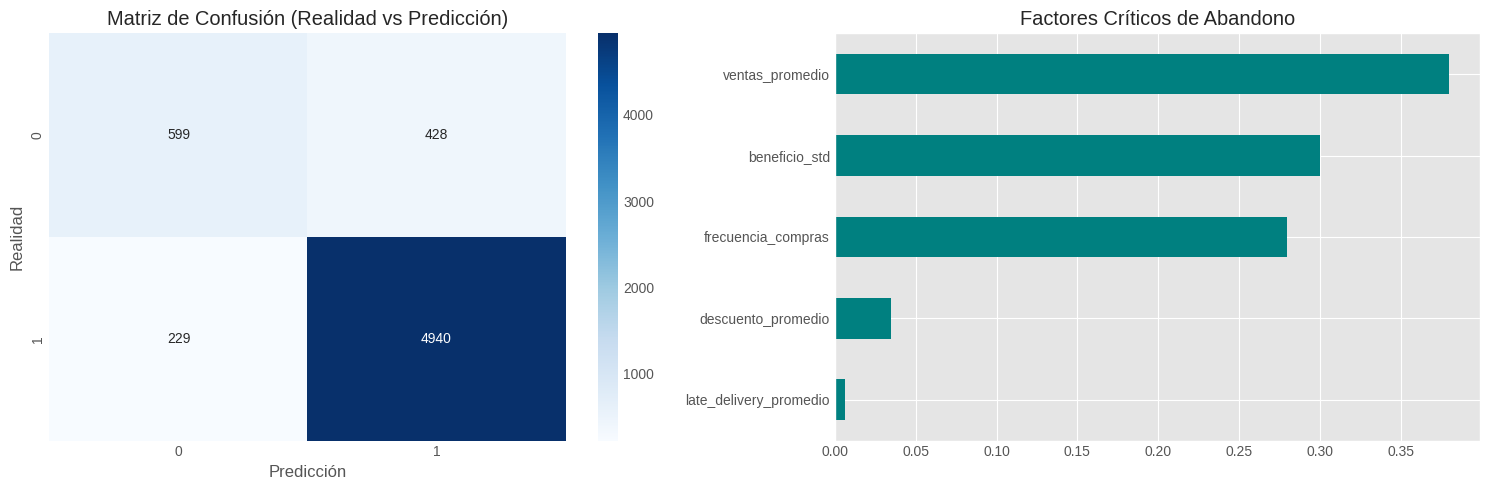


——————————————————————————————————————————————————
🔎 DIAGNÓSTICO DE RETENCIÓN | ID: 12395
——————————————————————————————————————————————————
📍 Ciudad: Coatzacoalcos | Región: Central America
⏰ Días de Inactividad: 1072
⚠️ Probabilidad de Abandono: 99.88%
Nivel de Alerta: CRÍTICO
Acción Sugerida: 🔴 ESTRATEGIA: Cupón de rescate 30% + Envío Priority.
——————————————————————————————————————————————————



In [54]:
# =================================================================
# ESTRATEGIA 360°: PREDICCIÓN DE CHURN, VALOR Y MÉTRICAS DE CONTROL
# =================================================================

import os
import gdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Configuración de estilo para la presentación
plt.style.use('ggplot')
sns.set_palette("viridis")

# 1. CARGA DEL DATASET
file_id = '1VNArYveijKBtBKdIo7YCbVQITWxuyTQc'
url_dataset = f'https://drive.google.com/uc?id={file_id}'
name_of_data = "DataCoSupplyChainDataset.csv"

if not os.path.exists(name_of_data):
    print("📥 Descargando dataset...")
    gdown.download(url_dataset, name_of_data, quiet=False)

df = pd.read_csv(name_of_data, encoding='latin-1')

# 2. FEATURE ENGINEERING Y MÉTRICAS DE CLIENTE
print("⚙️ Procesando ADN del cliente, Geografía y Valor de Vida (CLV)...")

df.dropna(subset=['Customer Id', 'order date (DateOrders)'], inplace=True)
df['order date (DateOrders)'] = pd.to_datetime(df['order date (DateOrders)'])
fecha_actual = df['order date (DateOrders)'].max()

# Agregamos variables de comportamiento, valor financiero y UBICACIÓN
cliente_df = df.groupby('Customer Id').agg({
    'order date (DateOrders)': lambda x: (fecha_actual - x.max()).days, # Recencia
    'Order Id': 'count',                                               # Frecuencia
    'Sales per customer': ['mean', 'sum'],                             # Valor
    'Benefit per order': ['mean', 'std'],                              # Rentabilidad
    'Late_delivery_risk': 'mean',                                      # Logística
    'Order Item Discount Rate': 'mean',                                # Sensibilidad precio
    'Order City': 'first',                                             # UBICACIÓN: Ciudad
    'Order Region': 'first',                                           # UBICACIÓN: Región
    'Category Name': lambda x: x.mode()[0] if not x.mode().empty else 'N/A' # Preferencia
}).reset_index()

# Aplanamos las columnas
cliente_df.columns = [
    'Customer Id', 'dias_desde_ultima_compra', 'frecuencia_compras',
    'ventas_promedio', 'Ventas_Totales', 'beneficio_promedio',
    'beneficio_std', 'late_delivery_promedio', 'descuento_promedio',
    'Ciudad', 'Region', 'Categoria_Favorita'
]
cliente_df.fillna(0, inplace=True)

# 3. ETIQUETADO DE RIESGO (Lógica de Negocio)
cliente_df['riesgo_abandono'] = (
    (cliente_df['dias_desde_ultima_compra'] > 60) |
    (cliente_df['beneficio_promedio'] < 0)
).astype(int)

# 4. SEGMENTACIÓN POR VALOR (Ranking VIP)
def segmentar_valor(row):
    if row['Ventas_Totales'] > cliente_df['Ventas_Totales'].quantile(0.8):
        return '🥇 VIP (Alto Valor)'
    elif row['Ventas_Totales'] > cliente_df['Ventas_Totales'].quantile(0.5):
        return '🥈 Potencial'
    else:
        return '🥉 Estándar'

cliente_df['Segmento_Valor'] = cliente_df.apply(segmentar_valor, axis=1)

# 5. ENTRENAMIENTO DEL MODELO (Gradient Boosting)
features = [
    'frecuencia_compras', 'late_delivery_promedio',
    'descuento_promedio', 'ventas_promedio', 'beneficio_std'
]

X = cliente_df[features]
y = cliente_df['riesgo_abandono']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

modelo_gb = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    random_state=42
)

modelo_gb.fit(X_train, y_train)

# Guardamos las probabilidades en el DataFrame principal
cliente_df['prob_abandono'] = modelo_gb.predict_proba(X)[:, 1]

# 6. FUNCIÓN DE DIAGNÓSTICO DE RETENCIÓN (EL FORMATO SOLICITADO)
def motor_diagnostico_retencion(id_cliente):
    """Genera el expediente visual de diagnóstico para el cliente."""
    cliente = cliente_df[cliente_df['Customer Id'] == id_cliente]
    if cliente.empty: return print("Cliente no encontrado")

    c = cliente.iloc[0]
    prob = c['prob_abandono']

    # Lógica de Alerta y Estrategia
    if prob > 0.70:
        nivel, emoji, accion = "CRÍTICO", "🔴", "Cupón de rescate 30% + Envío Priority."
    elif prob > 0.40:
        nivel, emoji, accion = "MODERADO", "🟡", "Encuesta de satisfacción + Descuento 15%."
    else:
        nivel, emoji, accion = "SALUDABLE", "🟢", "Mantener flujo VIP."

    print(f"\n{'—'*50}")
    print(f"🔎 DIAGNÓSTICO DE RETENCIÓN | ID: {id_cliente}")
    print(f"{'—'*50}")
    print(f"📍 Ciudad: {c['Ciudad']} | Región: {c['Region']}")
    print(f"⏰ Días de Inactividad: {int(c['dias_desde_ultima_compra'])}")
    print(f"⚠️ Probabilidad de Abandono: {prob*100:.2f}%")
    print(f"Nivel de Alerta: {nivel}")
    print(f"Acción Sugerida: {emoji} ESTRATEGIA: {accion}")
    print(f"{'—'*50}\n")

# 7. VISUALIZACIÓN DE MÉTRICAS (Rúbricas, Matriz y Estrategia)
def mostrar_visualizaciones():
    y_pred = modelo_gb.predict(X_test)
    y_prob = modelo_gb.predict_proba(X_test)[:, 1]

    print("\n" + "="*30)
    print("📊 RÚBRICAS DEL MODELO")
    print("="*30)
    print(classification_report(y_test, y_pred))
    print(f"AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

    # Visualización Profesional: Matriz e Importancia
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    # Gráfico 1: Matriz de Confusión
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[0])
    ax[0].set_title('Matriz de Confusión (Realidad vs Predicción)')
    ax[0].set_xlabel('Predicción')
    ax[0].set_ylabel('Realidad')

    # Gráfico 2: Importancia de Variables
    importancias = pd.Series(modelo_gb.feature_importances_, index=features).sort_values()
    importancias.plot(kind='barh', color='teal', ax=ax[1])
    ax[1].set_title('Factores Críticos de Abandono')

    plt.tight_layout()
    plt.show()

# --- EJECUCIÓN ---
mostrar_visualizaciones()

# Probar con el cliente con mayor riesgo detectado para validar el formato
id_ejemplo = cliente_df.sort_values('prob_abandono', ascending=False)['Customer Id'].iloc[0]
motor_diagnostico_retencion(id_ejemplo)

## Clarify Timeline Interpretation

### Subtask:
Provide a textual explanation regarding the 'timeline' aspect, clarifying that the current analysis focuses on 'before and after' in terms of understanding customer profitability before and after applying the clustering and anomaly detection models, rather than a direct time-series comparison over a historical period.


## Summary:

### Data Analysis Key Findings

*   **Overall Profitability (Baseline):** Before any segmentation or anomaly detection, the average benefit per order was \$21.97, and average sales per customer were \$183.10.
*   **Profitability by K-Prototypes Clusters:**
    *   **Cluster 0** showed the highest profitability, with an average benefit per order of \$1,289.11 and average sales per customer of \$5,323.20. This indicates a high-value customer segment.
    *   **Cluster 1** displayed the lowest profitability, with an average benefit per order of \$38.99 and average sales per customer of \$265.28.
    *   **Cluster 2** represented a mid-range segment, with an average benefit per order of \$307.34 and average sales per customer of \$2,403.47.
*   **Profitability by Anomaly Detection:**
    *   **Regular clients** exhibited positive profitability, with an average benefit per order of \$207.81 and average sales per customer of \$1,526.04.
    *   **Anomalous (rare) clients** showed a negative average benefit per order of -\$83.70, despite having significant average sales per customer of \$2,925.81. This highlights a critical segment that generates high sales but results in losses.

### Insights or Next Steps

*   The segmentation and anomaly detection models effectively differentiate customer groups with vastly different profitability profiles, moving beyond a single baseline average. This enables more targeted strategic interventions.
*   The finding that "anomalous" clients are unprofitable despite high sales warrants immediate investigation into the underlying causes (e.g., high return rates, excessive discounts, fraud) to mitigate losses and improve overall profitability.
